# CB_V_MAX

## Setup

In [ ]:
# If necessary:
import os
os.remove('snorkel.db')

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

## Parsing

In [ ]:
from snorkel import SnorkelSession
session = SnorkelSession()

### Define Parser

In [ ]:
import os
from snorkel.parser import CorpusParser, HTMLParser, OmniParser
from snorkel.utils import get_ORM_instance
from snorkel.queries import split_corpus

html_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware100_html/'
pdf_path  = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware100_pdf/'
doc_parser = HTMLParser(path=html_path)
context_parser = OmniParser(flatten=['span'], blacklist=['style'],
                            visual=True, pdf_path=pdf_path, session=session)
cp = CorpusParser(doc_parser, context_parser, max_docs=100) 

### Run Parser

In [ ]:
%time corpus = cp.parse_corpus(name='Hardware', session=session)

session.add(corpus)
session.commit()

### Split Corpus

In [ ]:
from snorkel.models import Corpus

corpus = get_ORM_instance(Corpus, session, 'Hardware')
split_corpus(session, corpus, train=0.8, development=0.2, test=0, seed=9)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ corpus');

## Extraction

In [ ]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ corpus snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

In [ ]:
from snorkel.models import candidate_subclass

Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

### Define Matchers

In [ ]:
from snorkel.matchers import RegexMatchSpan, Union

eeca_rgx = '([b]{1}[abcdefklnpqruyz]{1}[\swxyz]?[0-9]{3,5}[\s]?[A-Z\/]{0,5}[0-9]?[A-Z]?([-][A-Z0-9]{1,7})?([-][A-Z0-9]{1,2})?)'
eeca_matcher = RegexMatchSpan(rgx=eeca_rgx)
jedec_rgx = '([123]N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)'
jedec_matcher = RegexMatchSpan(rgx=jedec_rgx)
jis_rgx = '(2S[abcdefghjkmqrstvz]{1}[\d]{2,4})'
jis_matcher = RegexMatchSpan(rgx=jis_rgx)
others_rgx = '((NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|TIS|TIPL|DTC|MMBT|PZT){1}[\d]{2,4}[A-Z]{0,3}([-][A-Z0-9]{0,6})?([-][A-Z0-9]{0,1})?)'
others_matcher = RegexMatchSpan(rgx=others_rgx)
parts_rgx = '|'.join([eeca_rgx, jedec_rgx, jis_rgx, others_rgx])
parts_matcher = Union(eeca_matcher, jedec_matcher, jis_matcher, others_matcher)

#NOTE: This is super specific.
cb_v_matcher = RegexMatchSpan(rgx=r'\-?[2-8][0]', longest_match_only=False)

In [ ]:
# import re
# part_finder = re.compile(parts_rgx, re.I)
# print any([part_finder.match(x) for x in ['blue', 'red', 'black', 'green']])
# print any([part_finder.match(x) for x in ['blue', 'red', 'BC546A', 'green']])

### Define ContextSpaces

In [ ]:
import os
from collections import defaultdict
from hardware_utils import OmniNgramsPart, OmniNgramsTemp, get_gold_dict

# Make parts list
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
gold_parts = get_gold_dict(gold_file, doc_on=True, part_on=True, val_on=False)
parts_by_doc = defaultdict(set)
for part in gold_parts:
    parts_by_doc[part[0]].add(part[1])
    
part_ngrams = OmniNgramsPart(parts_by_doc=parts_by_doc, n_max=3)

# TODO: This is missing the current represented as an Amp rather than a milliamp
cb_v_ngrams = OmniNgramsTemp(n_max=3)

### Define Throttler

In [ ]:
from snorkel.lf_helpers import *

def cbv_throttler((part_span, attr_span)):
    """
    Keep only those candidates where both spans are on the same page and
    either aligned in the same table (visually or structurally) or the part is global.
    """
    return(
        same_page((part_span, attr_span)) and
        (part_span.parent.table is None or
        (same_row((part_span, attr_span)) or is_horz_aligned((part_span, attr_span)))))
#     """
#     Reject any candidates whose attributes are horizontally aligned with at least one 
#     part number and are not horizontally aligned with the candidate part number
#     """
#     return not (any(part_finder.match(word) for word in get_horz_aligned_ngrams(attr_span)) and 
#         not is_horz_aligned((part_span, attr_span)))

### Run CandidateExtractor

In [ ]:
from snorkel.models import Corpus
from snorkel.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance


ce = CandidateExtractor(Part_Voltage, 
                        [part_ngrams, cb_v_ngrams], 
                        [parts_matcher, cb_v_matcher],
                        throttler=cbv_throttler)

for corpus_name in ['Hardware Training', 'Hardware Development']:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = ce.extract(\
        corpus.documents, corpus_name + ' Candidates', session)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

### Assess Recall

In [ ]:
from hardware_utils import entity_level_total_recall, most_common_document, get_gold_dict
from snorkel.utils import get_ORM_instance
from snorkel.models import Candidate, Corpus

all_candidates = session.query(Candidate).all()
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'

corpus = get_ORM_instance(Corpus, session, 'Hardware')
(tp, fp, fn) = entity_level_total_recall(
    all_candidates, gold_file, 'cb_v_max', corpus=corpus, relation=True, integerize=True)
print len(tp)
print len(fp)
print len(fn)

In [ ]:
from pprint import pprint
fns = list(fn)
pprint(sorted(fns)[:10])

In [ ]:
# corpus = get_ORM_instance(Corpus, session, 'Hardware Training')
# for document in corpus.documents:
# #     print document.name
#     if document.name == 'MOTOS03160-1':
#         doc = document
# print doc

In [ ]:
# for c in all_candidates:
#     if c.part.get_span()=='BC183' and c.part.parent.document.name=='MOTOS03160-1':
#         print c

In [ ]:
# for phrase in doc.phrases:
#     if 'BC183' in phrase.words:
#         print phrase

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ candidates');

## Gold Labels

In [ ]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ candidates snorkel.db');

# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

In [ ]:
import os
from snorkel.models import CandidateSet
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
for set_name in ['Training', 'Development']:
    candidate_set_name = 'Hardware %s Candidates' % set_name
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % set_name
    annotation_key_name = 'Hardware %s Labels -- Gold' % set_name
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file, \
                           attrib='cb_v_max')
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ labels');

## Features

In [1]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ labels snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

### Extract Features

In [2]:
from snorkel.models import CandidateSet
from snorkel.fast_annotations import FeatureManager
from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Training Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Development Candidates')

feature_manager = FeatureManager()
%time F_train = feature_manager.create(session, train, 'Train Features')
%time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

[========================================] 100%
Bulk upserting 28518103 annotations...
Done.
Loading sparse Feature matrix...
CPU times: user 25min 19s, sys: 25min 29s, total: 50min 49s
Wall time: 1h 9min 50s
[========================================] 100%
Bulk upserting 8342429 annotations...
Done.
Loading sparse Feature matrix...
CPU times: user 10min 55s, sys: 9min 51s, total: 20min 47s
Wall time: 27min 6s


In [3]:
# If necessary:
import os
os.system('cp snorkel.db snorkel.db\ featurized');

[autoreload of snorkel.models.context failed: Traceback (most recent call last):
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
InvalidRequestError: Table 'corpus_document_association' is already defined for this MetaData instance.  Specify 'extend_existing=True' to redefine options and columns on an existing Table object.
]


## LFs

In [1]:
# If necessary
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ featurized snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])
from snorkel.models import CandidateSet
train = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates').one()
dev = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates').one()

CompileError: (in table 'label_vector', column 'keys'): Compiler <sqlalchemy.dialects.sqlite.base.SQLiteTypeCompiler object at 0x10acb2610> can't render element of type <class 'sqlalchemy.dialects.postgresql.base.ARRAY'>

### Define LFs

In [4]:
from snorkel.fast_annotations import LabelManager
from snorkel.lf_helpers import *
label_manager = LabelManager()

LFs = []

###################################################################
# BOTH
###################################################################

# cb_words_individual = set(['collector', 'base', 'voltage'])
# cb_words_together = set(['collector-base', 'voltage'])
cb_words = set(['collector base', 'collector-base', 'collector - base'])
def LF_cb_keywords_all(c):
    return 1 if overlap(cb_words, get_row_ngrams(c.voltage, spread=[0,3], n_max=3)) else -1
LFs.append(LF_cb_keywords_all)

###################################################################
# POSITIVE
###################################################################
    
pos_keys = set(['cbo', 'vcbo']) # 'value', 'rating'
def LF_pos_keywords_in_row(c):
    return 1 if overlap(pos_keys, get_row_ngrams(c.voltage, spread=[0,3])) else 0
LFs.append(LF_pos_keywords_in_row)

def LF_pos_keywords_horz(c):
    return 1 if overlap(pos_keys, get_horz_aligned_ngrams(c.voltage)) else 0
LFs.append(LF_pos_keywords_horz)

###################################################################
# NEGATIVE
###################################################################

eeca_rgx = '([b]{1}[abcdefklnpqruyz]{1}[\swxyz]?[0-9]{3,5}[\s]?[A-Z\/]{0,5}[0-9]?[A-Z]?([-][A-Z0-9]{1,7})?([-][A-Z0-9]{1,2})?)'
jedec_rgx = '([123]N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)'
jis_rgx = '(2S[abcdefghjkmqrstvz]{1}[\d]{2,4})'
others_rgx = '((NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|TIS|TIPL|DTC|MMBT|PZT){1}[\d]{2,4}[A-Z]{0,3}([-][A-Z0-9]{0,6})?([-][A-Z0-9]{0,1})?)'
parts_rgx = '|'.join([eeca_rgx, jedec_rgx, jis_rgx, others_rgx])
part_sniffer = re.compile(parts_rgx)
def LF_cheating_with_another_part(c):
    return -1 if (any(part_sniffer.match(x) for x in get_horz_aligned_ngrams(c)) and 
                     not is_horz_aligned(c)) else 0
LFs.append(LF_cheating_with_another_part)

def LF_same_table_must_align(c):
    part_row_ngrams    = list(get_row_ngrams(c.voltage, spread=[0,3], n_max=2))
    volt_row_ngrams = list(get_row_ngrams(c.voltage, spread=[0,3], n_max=2))
    return -1 if (overlap(part_row_ngrams, cb_words) and 
                  overlap(volt_row_ngrams, cb_words) and
                  not is_horz_aligned(c)) else 0
LFs.append(LF_same_table_must_align)

# A good LF, but made obsolete by the throttling condition
def LF_not_horz_aligned(c):
    return -1 if (same_table(c) and not is_horz_aligned(c)) else 0
LFs.append(LF_not_horz_aligned)

def LF_voltage_not_in_table(c):
    return -1 if c.voltage.parent.table is None else 0
LFs.append(LF_voltage_not_in_table)

def LF_low_table_num(c):
    return -1 if (c.voltage.parent.table and
        c.voltage.parent.table.position > 2) else 0
LFs.append(LF_low_table_num)

neg_keys = set(['continuous', 'emitter', 'cut-off', 'gain'])
def LF_specific_neg_row_keywords(c):
    return -1 if overlap(neg_keys, get_row_ngrams(c.voltage)) else 0
LFs.append(LF_specific_neg_row_keywords)

def LF_equals_in_row(c):
    return -1 if overlap('=', get_row_ngrams(c.voltage)) else 0
LFs.append(LF_equals_in_row)

def LF_i_in_row(c):
    return -1 if overlap('i', get_row_ngrams(c.voltage)) else 0
LFs.append(LF_i_in_row)

def LF_too_many_numbers_row(c):
    num_numbers = list(get_row_ngrams(c.voltage, attrib="ner_tags")).count('number')
    return -1 if num_numbers >= 4 else 0
LFs.append(LF_too_many_numbers_row)

In [ ]:
from snorkel.models import CandidateSet
from snorkel.utils import get_ORM_instance
from snorkel.utils import ProgressBar

# train = get_ORM_instance(CandidateSet, session, 'Hardware Training Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Development Candidates')

tp = set()
fp = set()
fn = set()
tn = set()
pb = ProgressBar(len(dev))

def heuristic(c): 
    return LF_cb_keywords_all(c) == 1 and not (
        LF_cheating_with_another_part(c) or
        LF_not_horz_aligned(c) or
        LF_voltage_not_in_table(c) or
        LF_same_table_must_align(c) or
        LF_specific_neg_row_keywords(c) or
        LF_equals_in_row(c) or
        LF_i_in_row(c) or
        LF_too_many_numbers_row(c)
        )

# from snorkel.utils import get_ORM_instance
# from snorkel.models import Candidate
# all_candidates = session.query(Candidate).all()

for i, c in enumerate(dev):
    pb.bar(i)
    if heuristic(c):
        tp.add(c)
    else:
        tn.add(c)
pb.close()

In [ ]:
print len(dev)
print len(tp) + len(tn)
print len(tp)
print len(tn)

### Apply LFs

In [5]:
%time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

[========================================] 100%
Bulk upserting 189132 annotations...
Done.
Loading sparse Label matrix...
CPU times: user 3min 19s, sys: 51 s, total: 4min 10s
Wall time: 4min 17s


<15761x12 sparse matrix of type '<type 'numpy.float64'>'
	with 58268 stored elements in Compressed Sparse Row format>

### Assess LF accuracy

In [6]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()
%time L_train.lf_stats(train_gold)

[========================================] 100%
CPU times: user 188 ms, sys: 26.4 ms, total: 214 ms
Wall time: 216 ms


,accuracy,conflicts,coverage,j,overlaps
LF_cb_keywords_all,0.712772,0.341539,1.000000,0,1.000000
LF_pos_keywords_in_row,0.482231,0.335639,0.335639,1,0.335639
LF_pos_keywords_horz,0.498353,0.154051,0.154051,2,0.154051
LF_cheating_with_another_part,0.711386,0.153607,0.240721,3,0.240721
LF_same_table_must_align,0.623160,0.193960,0.193960,4,0.193960
LF_not_horz_aligned,NaN,0.000000,0.000000,5,0.000000
LF_voltage_not_in_table,0.820893,0.015164,0.453080,6,0.453080
LF_low_table_num,0.642923,0.326375,0.546920,7,0.546920
LF_specific_neg_row_keywords,0.722573,0.031280,0.050314,8,0.050314
LF_equals_in_row,0.748655,0.078548,0.342047,9,0.342047


In [7]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ features');

## Learn and Evaluate

In [ ]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ features snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Voltage = candidate_subclass('Part_Voltage', ['part','voltage'])

In [8]:
from snorkel.fast_annotations import FeatureManager, LabelManager
from snorkel.models import CandidateSet
train = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates').one()
dev = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates').one()

feature_manager = FeatureManager()
%time F_train = feature_manager.load(session, train, 'Train Features')
%time F_dev = feature_manager.load(session, dev, 'Train Features')

label_manager = LabelManager()
%time L_train = label_manager.load(session, train, 'LF Labels')

CPU times: user 7min 20s, sys: 7min 35s, total: 14min 55s
Wall time: 19min 6s
CPU times: user 5min 4s, sys: 6min 39s, total: 11min 43s
Wall time: 17min 25s
CPU times: user 2.04 s, sys: 330 ms, total: 2.37 s
Wall time: 2.94 s


In [9]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=100000, rate=1e-6)
%time gen_model.save(session, 'Generative Params')
train_marginals = gen_model.marginals(L_train)

[autoreload of snorkel.models.context failed: Traceback (most recent call last):
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
InvalidRequestError: Table 'corpus_document_association' is already defined for this MetaData instance.  Specify 'extend_existing=True' to redefine options and columns on an existing Table object.
]
[autoreload of snorkel.features.table_features failed: Traceback (most recent call last):
  File "/Users/bradenhancock/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/Users/bradenhancock/snorkel/snorkel/features/table_features.py", line 68
    if span1.is_tabular() and span2.is_tabular()
                                               ^
SyntaxError: invalid syntax
]
/Users/bradenhancock/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: Use

Training marginals (!= 0.5):	15761
Features:			12
Begin training for rate=1e-06, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.308585
	Learning epoch = 250	Gradient mag. = 0.324781
	Learning epoch = 500	Gradient mag. = 0.324737
	Learning epoch = 750	Gradient mag. = 0.324692
	Learning epoch = 1000	Gradient mag. = 0.324647
	Learning epoch = 1250	Gradient mag. = 0.324602
	Learning epoch = 1500	Gradient mag. = 0.324558
	Learning epoch = 1750	Gradient mag. = 0.324513
	Learning epoch = 2000	Gradient mag. = 0.324468
	Learning epoch = 2250	Gradient mag. = 0.324423
	Learning epoch = 2500	Gradient mag. = 0.324378
	Learning epoch = 2750	Gradient mag. = 0.324333
	Learning epoch = 3000	Gradient mag. = 0.324288
	Learning epoch = 3250	Gradient mag. = 0.324243
	Learning epoch = 3500	Gradient mag. = 0.324198
	Learning epoch = 3750	Gradient mag. = 0.324153
	Learning epoch = 4000	Gradient mag. = 0.324108
	Learning epoch = 4250	Gradient mag. = 0.324063
	Learning epoch = 4500	Gradient mag. = 0.324018
	Lea

In [10]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-4)
%time disc_model.save(session, "Discriminative Params")

Training marginals (!= 0.5):	15718
Features:			48677
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 10894.887384	Gradient magnitude = 105276.472565
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 55233.757747	Gradient magnitude = 42026.933751
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 62844.685921	Gradient magnitude = 47236.127903
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 60480.248466	Gradient magnitude = 47026.486372
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 39363.169813	Gradient magnitude = 40281.842224
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 58669.716716	Gradient magnitude = 47003.826990
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 43986.172110	Gradient magnitude = 35826.612715
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 40561.432363	Gradient magnitude = 40105.616996
	Learning epoch = 800	Step size = 4.4914914861e-05
	Loss = 72392.894427	Gradi

Calibration plot:


/Users/bradenhancock/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


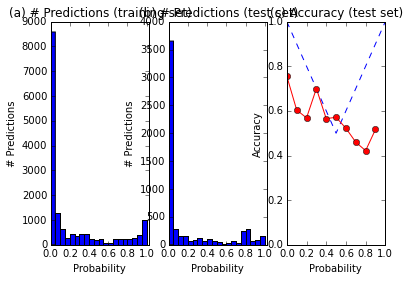

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.28156424581
Neg. class accuracy: 0.861915367483
Corpus Precision 0.475
Corpus Recall    0.282
Corpus F1        0.353
----------------------------------------
TP: 504 | FP: 558 | TN: 3483 | FN: 1286

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.28156424581
Neg. class accuracy: 0.861915367483
Corpus Precision 0.475
Corpus Recall    0.282
Corpus F1        0.353
----------------------------------------
TP: 504 | FP: 558 | TN: 3483 | FN: 1286



In [11]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()

dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates -- Gold').one()

from snorkel.models import CandidateSet
from snorkel.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Development Labels -- Gold')

tp, fp, tn, fn = disc_model.score(F_dev, L_dev, dev_gold)

In [12]:
from snorkel.models import Corpus
from snorkel.utils import get_ORM_instance
from hardware_utils import entity_level_f1
import os

dev_corpus = get_ORM_instance(Corpus, session, 'Hardware Development')

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Development').one()
(TP, FP, FN) = entity_level_f1(tp, fp, tn, fn, gold_file, dev_corpus, 'cb_v_max')

Scoring on Entity-Level Gold Data
Corpus Precision 0.536
Corpus Recall    0.804
Corpus F1        0.643
----------------------------------------
TP: 148 | FP: 128 | FN: 36



In [ ]:
from pprint import pprint
FN_list = sorted(list(FN))
FP_list = sorted(list(FP))
TP_list = sorted(list(TP))
# pprint(FN_list[:])
pprint(FN_list[:10])
# pprint(TP_list[:10])

In [ ]:
# docs = set()
# for doc in corpus.documents:
#     docs.add(doc.name.upper())
# pprint(docs)

In [ ]:
# import itertools
# docs = set()
# for f in itertools.chain.from_iterable([tp, tn, fp, fn]):
#     docs.add(f.part.parent.document.name.upper())
# #     if f.part.parent.document.name.upper() == 'AUKCS04635-1':
# #         print f
# pprint(docs)

In [ ]:
from hardware_utils import entity_to_candidates, part_error_analysis

# disc_model.get_feature_weights(F_dev)

entity = FN_list[0]
matches = entity_to_candidates(entity, dev)
print "Entity: (%d matches)" % len(matches)
print entity

stop = False
for i, c in enumerate(matches):
    part_error_analysis(c)
    results = []
    for lf in LFs:
        name = lf.__name__
        result = lf(c)
        results.append((name, result))
#         if name == 'LF_cb_keywords_all' and result == -1:
#             print name
#             ngrams = list(get_row_ngrams(c.voltage, spread=[0,3], n_max=3))
#             print ngrams
#             print overlap(ngrams, cb_words)
#             stop = False
#         if name == 'LF_cheating_with_another_part' and result == -1:
#             print name
#             horz_ngrams = list(get_horz_aligned_ngrams(c))
#             print horz_ngrams
#             print [part_sniffer.match(x) for x in horz_ngrams]
#             stop = False
        if name == 'LF_i_in_row' and result == -1:
            print name
            ngrams = list(get_row_ngrams(c.voltage, spread=[0,3], n_max=3))
            print ngrams
            stop = False
        if stop: break
    print "MATCH %d:" % i
    print heuristic(c)
    pprint(results)
    print "--------------------------------------------------------------------------------"
    if stop: break
    
#     if heuristic(candidate):
#         print "\nCandidate:"
# #         print candidate
#         print part_error_analysis(candidate)
#     print heuristic(candidate)
#     print LF_voltage_not_in_table(candidate)
#         print candidate.voltage.parent.table
#     print "\nScore:"
#     print disc_model.get_candidate_score(candidate, F_dev)

#     print "\nFeatures:"
#     pprint(disc_model.get_candidate_feature_weights(candidate, F_dev))

In [ ]:
print cb_words

In [ ]:
candidate[0].parent.text

In [ ]:
candidate[0].get_span()

In [ ]:
results = []
for lf in LFs:
    results.append(lf.__name__, lf(candidate))

In [ ]:
print F_train.shape
print F_dev.shape

In [ ]:
import os
os.system('cp snorkel.db snorkel.db\ final');

In [ ]:
# def LF_first_row(c):
#     if c.voltage.parent.row_num == 0:
#         return -1
#     else:
#         return 0
# LFs.append(LF_first_row)
    
# def LF_not_ce_relevant(c):
#     ce_keywords = set(['collector', 'emitter', 'collector-emitter'])
#     ngrams = set(get_aligned_ngrams(c.voltage))
#     if not set_any_in_set(ce_keywords, ngrams):
#         return -1
#     else:
#         return 1
# LFs.append(LF_not_ce_relevant)

# def LF_negative_keywords(c):
#     row_neg_keys = set(['ambient',
#                     'small-signal',
#                     'cut-off',
#                     'na',
#                     'ma',
#                     'cex',
#                     'resistance',
#                     'power',
#                     'junction',
#                     'dissipation', 
#                     'breakdown',
#                     'current',
#                     'ceo',
#                     'vceo'
#                     'peak',
#                     '=',
#                     'f',
#                     'p',
#                     'base',
#                     'mw',
#                     'ebo',
#                     'vebo',
#                     'i c',
#                     'total',
#                     'device',
#                     'c',
#                     'mhz',
#                     'temperature',
#                     'saturation',
#                     'operating',
#                     'storage'
#                     'bandwidth',
#                     'derate',
#                     'above',
#                     'product',
#                     'figure',
#                     'conditions',
#                     'current gain',
#                     'saturation',
#                     'min',
#                     'min.',
#                     'typ',
#                     'typ.',
#                     'max',
#                     'max.',
#                     'gain',
#                     'p',
#                     'thermal',
#                     'test'])
#     row_ngrams = set(get_row_ngrams(c.voltage))
#     col_ngrams = set(get_col_ngrams(c.voltage))
#     col_neg_keys = set(['conditions', 
#                         'condition', 
#                         'parameter', 
#                         'min',
#                         'min.',
#                         'typ',
#                         'typ.',
#                         'max',
#                         'max.',
#                         'test'])
#     if set_any_in_set(row_neg_keys, row_ngrams):
#         return -1
#     if set_any_in_set(col_neg_keys, col_ngrams):
#         return -1
#     return 0
# LFs.append(LF_negative_keywords)
    
# def LF_negative_keywords_in_col(c):
#     neg_keys = set(['conditions',
#                     'condition',
#                     'parameter',
#                     'test'])
#     ngrams = set(get_col_ngrams(c.voltage))
#     if set_any_in_set(neg_keys, ngrams):
#         return -1
#     else:
#         return 0

# LFs.append(LF_negative_keywords_in_col)

# def LF_negative_keywords_in_part_aligned(c):
#     ngrams = set(get_aligned_ngrams(c.part))
#     return -1 if (
#         'gain'          in ngrams or
#         'small-signal'  in ngrams or
#         'small'         in ngrams or
#         'cbo'         in ngrams or
#         'collector-emitter' in ngrams or
#         'value'         in ngrams or
#         'thermal'       in ngrams) else 0
# LFs.append(LF_negative_keywords_in_part_aligned)

# def LF_negative_keywords(c):
#     ngrams = set(get_aligned_ngrams(c.voltage))
#     return -1 if (
#         'collector-base'    in ngrams or
#         'cut-off'           in ngrams or
#         '='                 in ngrams or
#         'gain'              in ngrams or
#         'h fe'              in ngrams or
#         'typ.'              in ngrams or
#         'typ'               in ngrams or
#         'min'               in ngrams or
#         'min.'              in ngrams or
#         'saturation'        in ngrams or
#         'mhz'               in ngrams or
#         'gain'              in ngrams or
#         'obo'               in ngrams or
#         'c obo'             in ngrams) else 0
# LFs.append(LF_negative_keywords)
